# Using a dedicated datamodule to perform inference: the crop classification example. 

### To run this example, the following packages are necessary.

In [1]:
!pip install terratorch gdown tensorboard >& install.log

In [2]:
import os
import sys
import torch
import gdown
import terratorch
import albumentations
import lightning.pytorch as pl
import matplotlib.pyplot as plt
from terratorch.datamodules import MultiTemporalCropClassificationDataModule
import warnings
warnings.filterwarnings('ignore')

/home/jalmeida/.pyenv/versions/3.12.7/envs/sbsr/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Downloading a random subset of the required dataset (~1 GB).

In [3]:
if not os.path.isfile('multi-temporal-crop-classification-subset.tar.gz'):
    !gdown 1LL6thkuKA0kVyMI39PxgsrJ1FJJDV7-u

if not os.path.isdir('multi-temporal-crop-classification-subset/'):
    !tar -xzvf multi-temporal-crop-classification-subset.tar.gz

dataset_path = "multi-temporal-crop-classification-subset"

### Instantiating the corresponding datamodule. 

In [4]:
datamodule = MultiTemporalCropClassificationDataModule(
    batch_size=8,
    num_workers=2,
    data_root=dataset_path,
    train_transform=[
        terratorch.datasets.transforms.FlattenTemporalIntoChannels(),  # Required for temporal data
        albumentations.D4(), # Random flips and rotation
        albumentations.pytorch.transforms.ToTensorV2(),
        terratorch.datasets.transforms.UnflattenTemporalFromChannels(n_timesteps=3),
    ],
    val_transform=None,  # Using ToTensor() by default
    test_transform=None,
    expand_temporal_dimension=True,
    use_metadata=False, # The crop dataset has metadata for location and time
    reduce_zero_label=True,
)

# Setup train and val datasets
datamodule.setup("predict")

### Visualizing a few samples. 

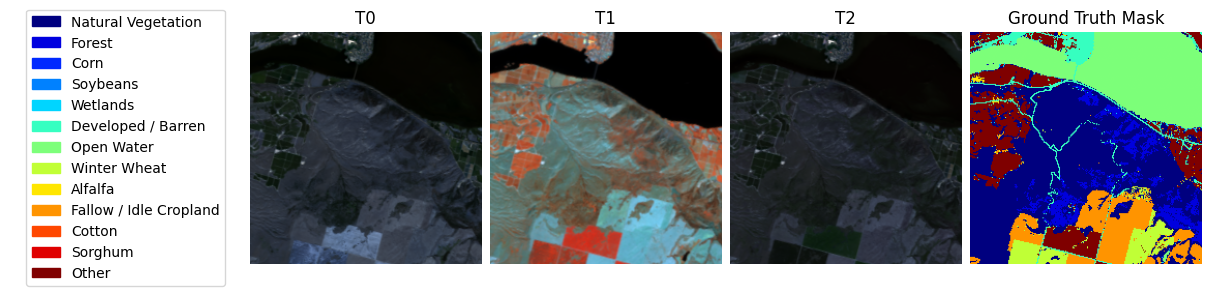

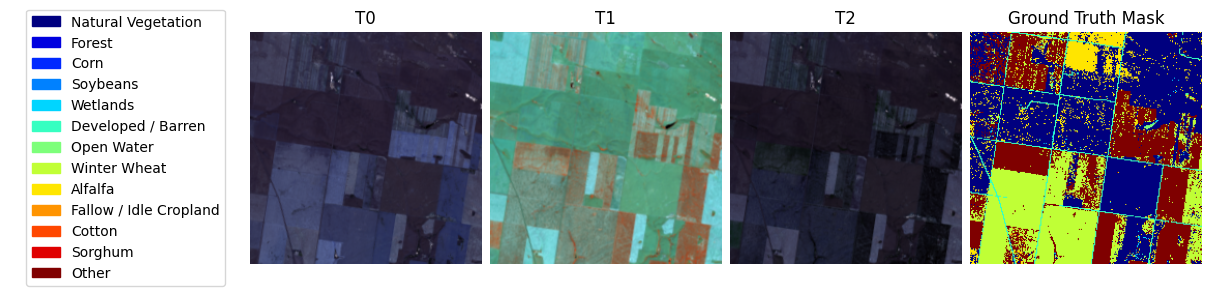

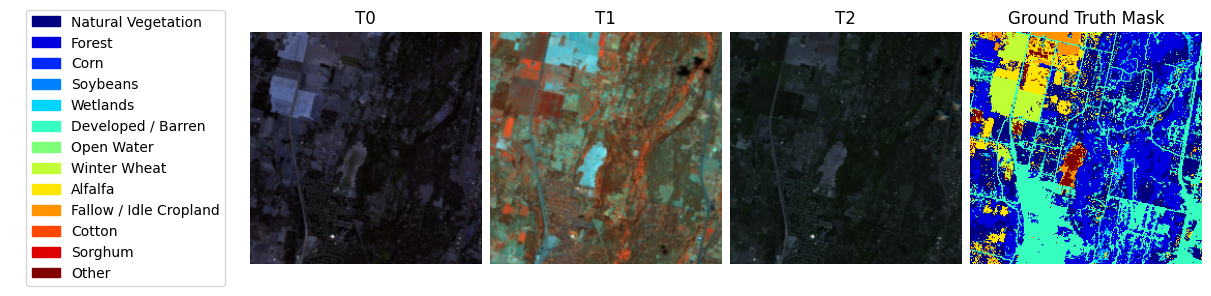

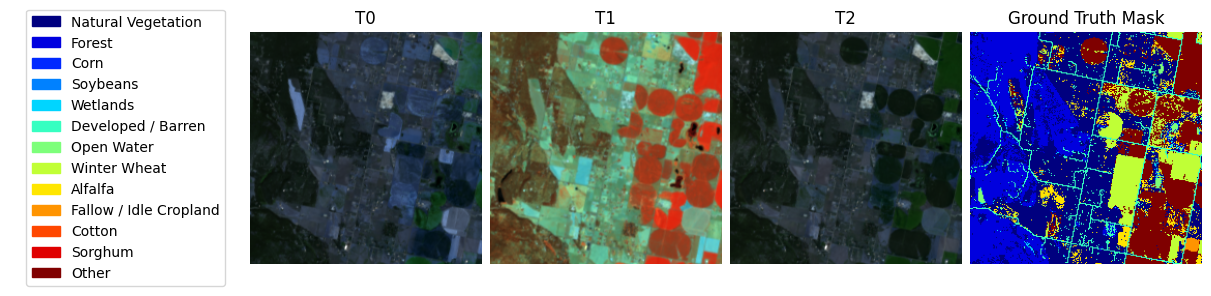

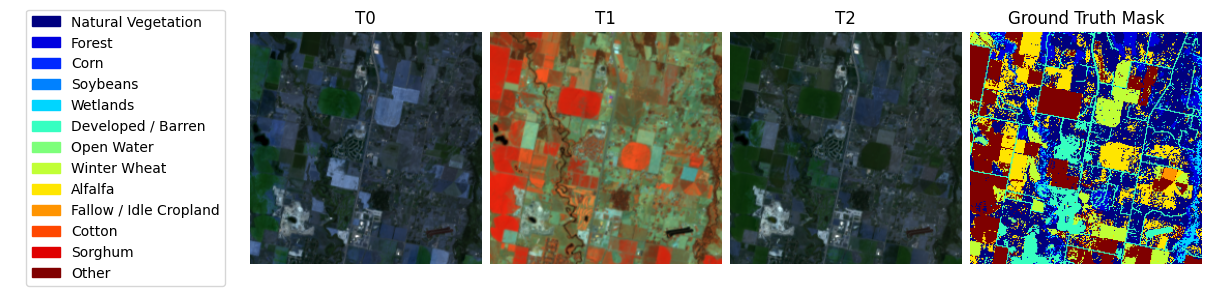

In [5]:
for i in range(5):
    datamodule.predict_dataset.plot(datamodule.predict_dataset[i])

### Downloading the best pretrained checkpoint. 

In [6]:
best_ckpt_100_epoch_path = "multicrop_best-epoch=76.ckpt"

if not os.path.isfile(best_ckpt_100_epoch_path):
    gdown.download("https://drive.google.com/uc?id=1o1Hzd4yyiKyYdzfotQlEOeGTjsM8cHSw")

### Instantiating the Lightning Trainer.

In [7]:
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    dirpath="output/multicrop/checkpoints/",
    mode="max",
    monitor="val/Multiclass_Jaccard_Index", # Variable to monitor
    filename="best-{epoch:02d}",
)
trainer = pl.Trainer(
    accelerator="auto",
    strategy="auto",
    devices=1, # Lightning multi-gpu often fails in notebooks
    precision='bf16-mixed',  # Speed up training
    num_nodes=1,
    logger=True, # Uses TensorBoard by default
    max_epochs=1, # For demos
    log_every_n_steps=5,
    enable_checkpointing=True,
    callbacks=[checkpoint_callback, pl.callbacks.RichProgressBar()],
    default_root_dir="output/multicrop",
)

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


### Instantiating the task to handle the model.

In [8]:
model = terratorch.tasks.SemanticSegmentationTask(
    model_factory="EncoderDecoderFactory",
    model_args={
        # Backbone
        "backbone": "prithvi_eo_v2_300", # Model can be either prithvi_eo_v1_100, prithvi_eo_v2_300, prithvi_eo_v2_300_tl, prithvi_eo_v2_600, prithvi_eo_v2_600_tl
        "backbone_pretrained": True,
        "backbone_num_frames": 3,
        "backbone_bands": ["BLUE", "GREEN", "RED", "NIR_NARROW", "SWIR_1", "SWIR_2"],
        "backbone_coords_encoding": [], # use ["time", "location"] for time and location metadata
        
        # Necks 
        "necks": [
            {
                "name": "SelectIndices",
                # "indices": [2, 5, 8, 11] # indices for prithvi_eo_v1_100
                "indices": [5, 11, 17, 23] # indices for prithvi_eo_v2_300
                # "indices": [7, 15, 23, 31] # indices for prithvi_eo_v2_600
            },
            {
                "name": "ReshapeTokensToImage",
                "effective_time_dim": 3
            },
            {"name": "LearnedInterpolateToPyramidal"},            
        ],
        
        # Decoder
        "decoder": "UNetDecoder",
        "decoder_channels": [512, 256, 128, 64],
        
        # Head
        "head_dropout": 0.1,
        "num_classes": 13,
    },
    
    loss="ce",
    lr=1e-4,
    optimizer="AdamW",
    ignore_index=-1,
    freeze_backbone=True,  # Speeds up fine-tuning
    freeze_decoder=False,
    plot_on_val=True,
    
)

INFO:root:Loaded weights for HLSBands.BLUE in position 0 of patch embed
INFO:root:Loaded weights for HLSBands.GREEN in position 1 of patch embed
INFO:root:Loaded weights for HLSBands.RED in position 2 of patch embed
INFO:root:Loaded weights for HLSBands.NIR_NARROW in position 3 of patch embed
INFO:root:Loaded weights for HLSBands.SWIR_1 in position 4 of patch embed
INFO:root:Loaded weights for HLSBands.SWIR_2 in position 5 of patch embed


### Predicting for some samples in the prediction dataset.

You are using a CUDA device ('NVIDIA RTX A4500 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Restoring states from the checkpoint path at multicrop_best-epoch=76.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at multicrop_best-epoch=76.ckpt


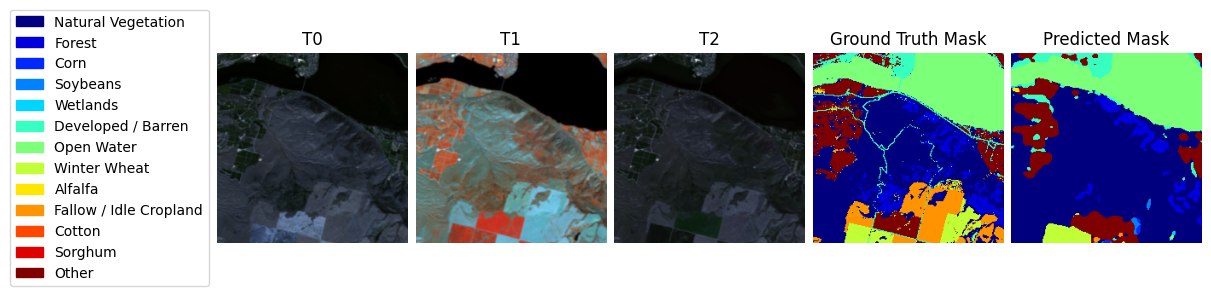

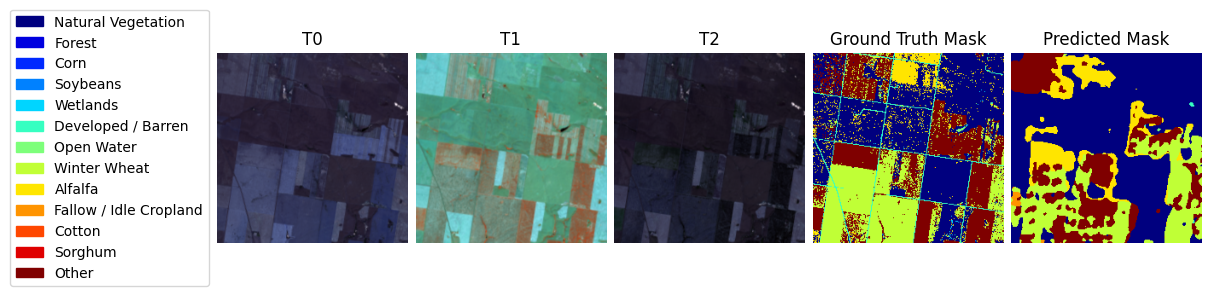

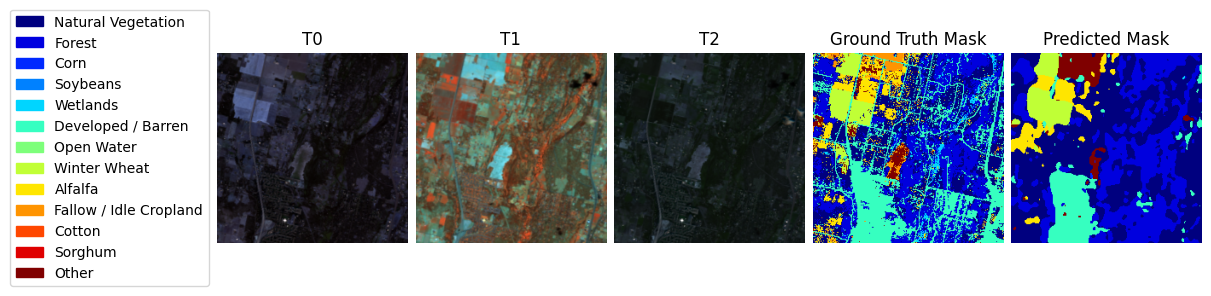

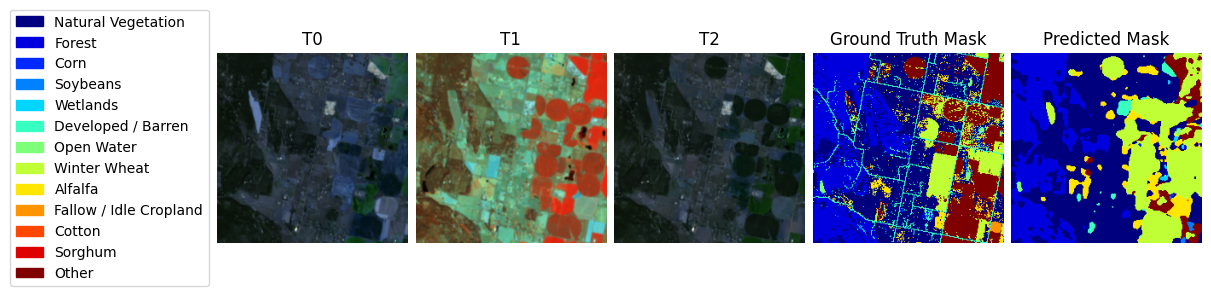

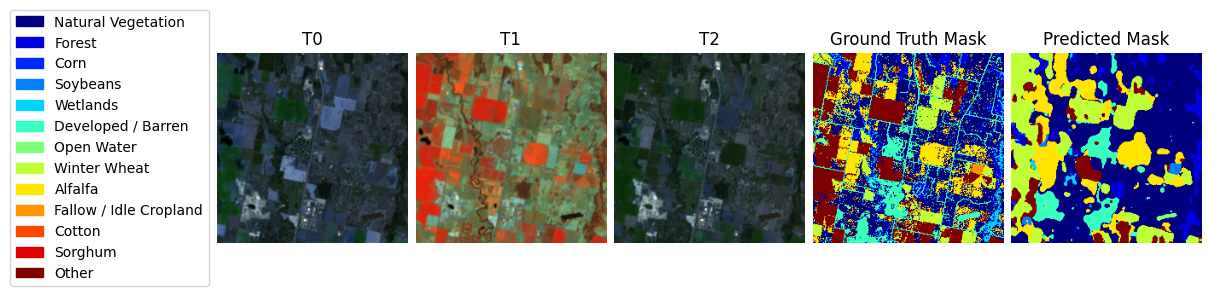

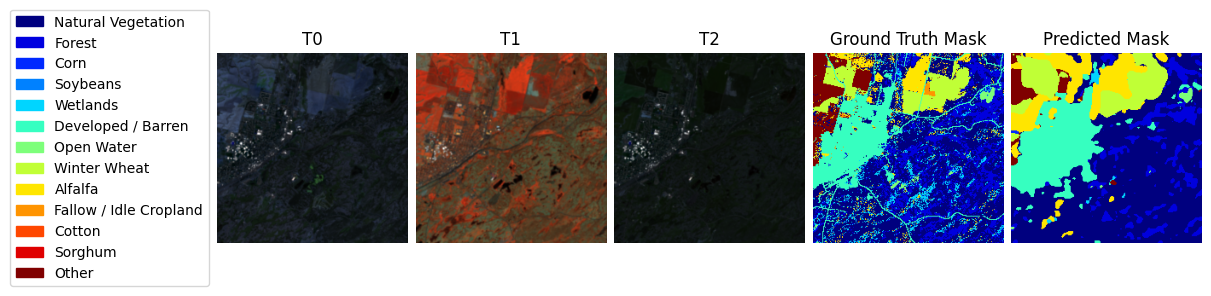

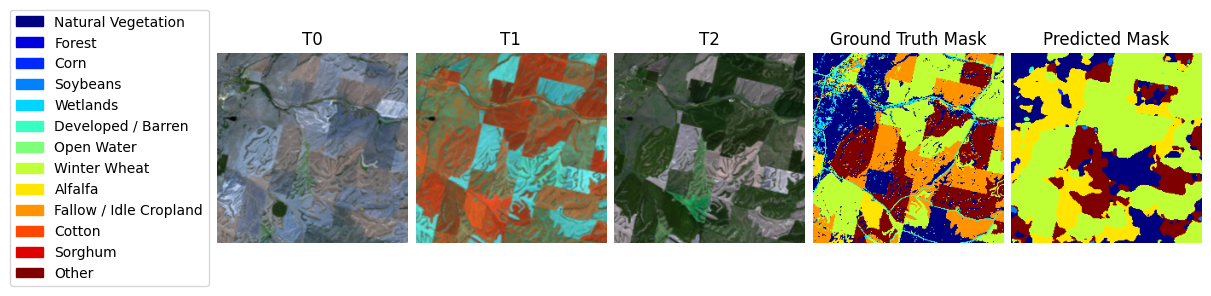

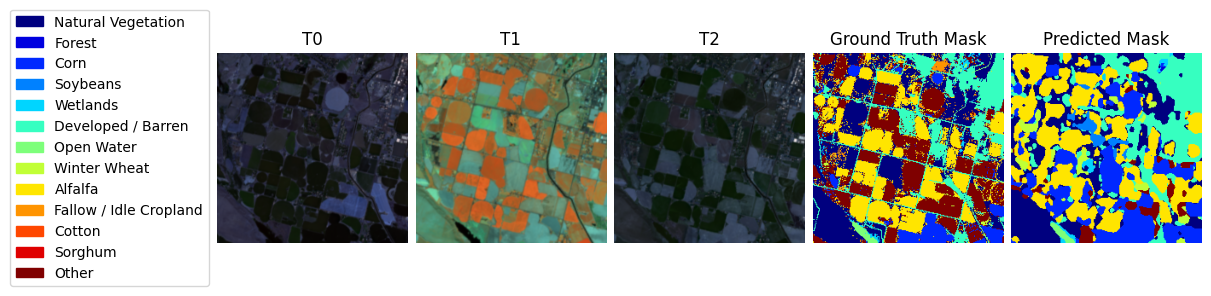

In [9]:
preds = trainer.predict(model, datamodule=datamodule, ckpt_path=best_ckpt_100_epoch_path)
# get data 
data_loader = trainer.predict_dataloaders
batch = next(iter(data_loader))

# plot
BATCH_SIZE = 8
for i in range(BATCH_SIZE):

    sample = {key: batch[key][i] for key in batch}
    sample["prediction"] = preds[0][0][i].cpu().numpy()

    datamodule.predict_dataset.plot(sample)